# <center> Code Report </center>
曹妍 220040021
刘丹蕾 220040014
薛力 115020292
周亚楠 115010302
## Part A: 构建函数

### 1.1. 导入需要的程辑包

In [145]:
import pandas as pd
import numpy as np
import tushare as ts
import math
from math import log, sqrt, exp
from scipy.stats import norm
import matplotlib.pyplot as plt

### 1.2. 下载数据

In [146]:
class download_data():

    def __init__(self, SC, sta_date, end_date):
        self.SC = SC
        self.sta_date = sta_date
        self.end_date = end_date
        self.token = "d44cbc9ab3e7c25e5dfcbe6437ac061b125395567ad582806d02d38c"
        self.pro = ts.pro_api(self.token)

    def get_stock_code(self):
        """
        获取股票代码
        """
        return self.SC

    def set_stock_code(self, SC):
        """
        设置股票代码
        """
        self.SC = SC

    def get_stock_data(self):
        """
        获取股票交易数据
        """
        df = self.pro.daily(ts_code=self.SC,
                            start_date = self.sta_date,
                            end_date=self.end_date)
        df.index = pd.to_datetime(df["trade_date"], format="%Y%m%d")
        df.sort_index(inplace=True)
        return df

    def get_fund_data(self):
        """
        获取基金交易数据
        """
        df = self.pro.fund_daily(ts_code=self.SC,
                            start_date = self.sta_date,
                            end_date=self.end_date)
        df.index = pd.to_datetime(df["trade_date"], format="%Y%m%d")
        df.sort_index(inplace=True)
        return df

    def get_dividend(self):
        """
        获取股票股息
        """
        # pro.dividend(ts_code=SC, fields='ts_code,div_proc,stk_div,record_date,ex_date')
        df = self.pro.dividend(ts_code=self.SC, fields='ts_code,div_proc,stk_div,record_date,ex_date')
        return df

    def get_fund_dividend(self):
        """
        获取基金股息
        """
        # pro.dividend(ts_code=SC, fields='ts_code,div_proc,stk_div,record_date,ex_date')
        df = self.pro.fund_div(ts_code=self.SC, fields='ts_code,div_proc,stk_div,record_date,ex_date')
        return df


    def get_r(self, type = "shibor"):
        """
        得到无风险利率
        :param type: 采用的是上海银行拆借利率shibor
        :return: 返回的是年利率，一个DataFrame
        """
        if type == "libor":
            df = self.pro.libor(curr_type='USD',
                                start_date=self.sta_date,
                                end_date=self.end_date)
        if type == "shibor":
            df = self.pro.shibor(start_date=self.sta_date,
                                 end_date=self.end_date)
        if type == "hibor":
            df = self.pro.hibor(curr_type='RMB',
                                start_date=self.sta_date,
                                end_date=self.end_date)

        df.index = pd.to_datetime(df["date"], format="%Y%m%d")
        df.sort_index(inplace=True)
        return df["1y"]

### 2.1. 获取历史波动率

In [147]:
def get_volatility(df, method = "percentage"):
    """
    得到一直股票的历史波动率
    :param df: 股票的历史数据，最好采用每天的收盘价
    :param method: 有两种方法，默认的是百分比法
    :return:
    """
    # df = close
    length = df.shape[0]
    Xi_list = []
    for i in range(0, length-1):
        # i = 0

        # 百分比价格变动法
        if method == "percentage":
            Xi = (df.iloc[i+1] - df.iloc[i]) / df.iloc[i]

        # 对数价格变动法
        elif method == "logarithm":
            Xi = math.log(df.iloc[i + 1]) - math.log(df.iloc[i])

        Xi_list.append(Xi)
    Xi_list = np.array(Xi_list)
    X_bar = Xi_list.mean()
    sigma = math.sqrt(sum([(x - X_bar)**2 for x in Xi_list]))
    return sigma

def find_hist_sigma(SC):
    Project = download_data(SC, '20100101', '20190101')
    close_data = Project.get_stock_data()["close"]
    sigma = get_volatility(close_data)
    return sigma

def find_hist_sigma_fund(SC):
    Project = download_data(SC, '20100101', '20190101')
    close_data = Project.get_fund_data()["close"]
    sigma = get_volatility(close_data)
    return sigma

### 2.2. 定义期权公式

In [148]:
def get_option_by_s(ST, X, alpha = 0.3):
    """
    这个期权与股票S的关系，分为三种情况
    :param ST: 股票在t=T的时候的价格
    :param X: Strike Price
    :param alpha: 定价因子alpha，在(0, 1)之间
    :return: 返回的是期权的价格
    """
    if alpha * ST >= ST - X >= 0:
        option = ST - X
    if ST - X > alpha * ST:
        option = alpha * ST
    if ST - X < 0:
        option = 0
    return option

### 2.3. 定义单步二叉树

In [149]:
def Price_by_BT_2(r, sigma, delta, X, S0, h, alpha = 0.3):
    """
    :param r: 无风险利率
    :param sigma: 历史波动率
    :param delta: 股息dividend
    :param X: Strike Price
    :param S0: 股票在t=0的价格
    :param h: 一次二叉树的时间
    :param alpha: 奇异期权的定价因子
    :return: 返回的是一个dictionary
    """

    u = math.exp((r-delta) * h + sigma*math.sqrt(h))
    d = math.exp((r-delta) * h - sigma*math.sqrt(h))
    p = (math.exp((r-delta) * h) - d)/(u-d)
    q = 1 - p
    uS = u * S0
    dS = d * S0
    uOp = get_option_by_s(uS, X, alpha)
    dOp = get_option_by_s(dS, X, alpha)
    sanjiao = math.exp(-delta*h) * (uOp - dOp)/(S0*(u-d))
    B = math.exp(-r*h) * (u * dOp - d * uOp)/(u-d)
    output_dic = {"Call_Up":uOp,
                  "Call_down":dOp,
                  "Stock_Up":uS,
                  "Stock_Down":dS,
                  "Up_factor":u,
                  "Down_factor":d,
                  "p_star":p,
                  "delta":sanjiao,
                  "B":B}
    return output_dic


### 3.1. 定义欧式期权二叉树模型

In [150]:
def Build_Tree_E(n, r, sigma, delta, X, S0, h, alpha):
    """
    欧式期权的二叉树
    :param n: 进行n次回归
    :param r: 无风险利率
    :param sigma: 历史波动率
    :param delta: dividend的
    :param X: Strike Price
    :param S0_P: 之前股票的价格
    :param h: 每次二叉树的间隔
    :param alpha: 这个是奇异期权的定价中的变量alpha
    :return: 返回是一个嵌套list
    """

    stock_matrix = np.zeros((n+1)*(n+1)).reshape(((n+1), (n+1)))
    option_matrix = np.zeros((n+1)*(n+1)).reshape(((n+1), (n+1)))
    stock_matrix[0, 0] = S0
    for j in range(0, n):
        for i in range(0, j+1):
            S0_P = stock_matrix[i][j]
            if j != i:
                stock_matrix[i, j+1] = Price_by_BT_2(r, sigma, delta,
                                                     X, S0_P, h, alpha)["Stock_Up"]
            if j == i:
                stock_matrix[i, j+1] = Price_by_BT_2(r, sigma, delta,
                                                     X, S0_P, h, alpha)["Stock_Up"]
                stock_matrix[i+1, j+1] = Price_by_BT_2(r, sigma, delta,
                                                       X, S0_P, h, alpha)["Stock_Down"]
    p = Price_by_BT_2(r, sigma, delta, X, S0, h, alpha)["p_star"]
    q = 1 - p
    for i in range(0, n+1):
        option_matrix[i, n] = get_option_by_s(stock_matrix[i, n], X, alpha)
    for j in range(n-1, -1, -1):
        for i in range(0, j+1):
            # print(i, j)
            option_matrix[i, j] = p * option_matrix[i, j+1] + q * option_matrix[i+1, j+1]
    return option_matrix

### 3.2. 定义美式期权二叉树模型

In [151]:
def Build_Tree_A(n, r, sigma, delta, X, S0, h, alpha):
    """
    美式期权的二叉树
    :param n: 进行n次回归
    :param r: 无风险利率
    :param sigma: 历史波动率
    :param delta: dividend的
    :param X: Strike Price
    :param S0_P: 之前股票的价格
    :param h: 每次二叉树的间隔
    :param alpha: 这个是奇异期权的定价中的变量alpha
    :return: 返回是一个嵌套list
    """

    stock_matrix = np.zeros((n+1)*(n+1)).reshape(((n+1), (n+1)))
    option_matrix = np.zeros((n+1)*(n+1)).reshape(((n+1), (n+1)))
    stock_matrix[0, 0] = S0
    for j in range(0, n):
        for i in range(0, j+1):
            S0_P = stock_matrix[i][j]
            if j != i:
                stock_matrix[i, j+1] = Price_by_BT_2(r, sigma, delta,
                                                     X, S0_P, h, alpha)["Stock_Up"]
            if j == i:
                stock_matrix[i, j+1] = Price_by_BT_2(r, sigma, delta,
                                                     X, S0_P, h, alpha)["Stock_Up"]
                stock_matrix[i+1, j+1] = Price_by_BT_2(r, sigma, delta,
                                                       X, S0_P, h, alpha)["Stock_Down"]

    p = Price_by_BT_2(r, sigma, delta, X, S0, h, alpha)["p_star"]
    q = 1 - p
    for i in range(0, n+1):
        option_matrix[i, n] = get_option_by_s(stock_matrix[i, n], X, alpha)
    for j in range(n-1, -1, -1):
        for i in range(0, j+1):
            # print(i, j)
            price_1 = p * option_matrix[i, j+1] + q * option_matrix[i+1, j+1]
            price_2 = get_option_by_s(stock_matrix[i, j], X, alpha)
            option_matrix[i, j] = max(price_1, price_2)

    return option_matrix


# r = 0.035
# n = 10
# delta = 0.02
# sigma = 1.2
# h = 1/365
# X = 120
# S0 = 100
# alpha = 0.3
# a = Build_Tree_A(n, r, sigma, delta, X, S0, h, alpha)
# b = Build_Tree_E(n, r, sigma, delta, X, S0, h, alpha)

### 4.1. 欧式期权的 Black Scholes Model

In [152]:
def dnd(d):
        return np.exp(-0.5*d**2)/sqrt(2*math.pi)
    
def BS_Formular(X, alpha, sigma, delta, r, ST, T, t):
    """
    Black Scholes Model
    以及得出欧式期权的Greeks
    """
    K = X/(1 - alpha)

    d1 = (log(ST/X) + r - delta + 0.5*sigma**2)/(sigma*sqrt(T-t))

    d2 = d1 - sigma*sqrt(T-t)

    d3 = (log(ST/K) + r - delta + 0.5*sigma**2)/(sigma*sqrt(T-t))

    d4 = d3 - sigma*sqrt(T-t)

    Δ = np.exp(-delta*(T-t)) * norm.cdf(d1) \
        - (1-alpha) * np.exp(-delta*(T-t)) * norm.cdf(d3)

    gamma = np.exp(-delta*(T-t))*dnd(d1)/(ST*sigma*sqrt(T-t)) \
            - (1-alpha)*np.exp(-delta*(T-t))*dnd(d3)/(ST*sigma*sqrt(T-t))
    
    theta = delta*ST*np.exp(-delta*(T-t))*norm.cdf(d1) \
            - r*X*np.exp(-r*(T-t))*norm.cdf(d2) \
            - (X*np.exp(-r*(T-t))*dnd(d2)*sigma/(2*sqrt(T-t))) \
            - (1-alpha)*(delta*ST*np.exp(-delta*(T-t)) * norm.cdf(d3) \
            - r*K*np.exp(-r*(T-t))*norm.cdf(d4) \
            - K*np.exp(-r*(T-t))*dnd(d4)*sigma/2*sqrt(T-t))

    return [Δ, gamma, theta]

### 4.2. 美式期权的 Black Scholes Model

In [153]:
#American case. Use binomial tree
def greeks_America(r, sigma, delta, X, S, alpha):
    """
    用二分法得到美式期权的Greeks
    """
    h=1/365
    u=Price_by_BT_2(r, sigma, delta, X, S, alpha)['Up_factor']
    d=Price_by_BT_2(r, sigma, delta, X, S, alpha)['Down_factor']
    V=Build_Tree_A(2, r, sigma, delta, X, S, h,alpha)
    V0=V[0][0]
    V11,V10=V[0][1],V[1][1]
    V22,V21,V20=V[0][2],V[1][2],V[2][2]
    Δ=(V11-V10)/(S*(u-d))
    #有限差分法
    #gamma=((V22-V21)/(S*u*u-S)-(V21-V20)/(S-S*d*d))/(0.5*S*(u**2-d**2))
    #theta=(V21-V0)/(2)
    #binomial tree
    gamma=((V22-V21)/(S*u*u-d*S)-(V21-V20)/(S-S*d*d))/(0.5*S*(u**2-d**2))
    theta=(V21-V0)/2
    return [Δ,gamma,theta]

### 4.3. 用 BS 模型定价

In [154]:
def cal_greeks(data, X, r, sigma, delta, alpha, Optype):
    """
    计算每天的Greeks， 以及画出相关的图像
    :param data: 股票或基金数据
    :param X: 行权价格
    :param r: 无风险利率
    :param sigma: 波动率
    :param delta: dividend股息
    :param alpha: alpha的大小
    :param Optype: Option的类型
    """
    #读取股价
    St=data

    #设置参数
    S0=St[0]
    T=1
    K=X
    q = delta #股息

    #读取期权价格
    option=pd.Series([get_option_by_s(x, K, alpha) for x in St],index=St.index)

    if Optype=="e":
    #European case
        TL=[0.3,1,3]
        plt.figure(figsize=(12,3))
        plt.title("delta")
        S0=St[0]
        for T in TL:
            plt.plot(list(np.arange(S0*0.1,S0*1.5,S0/500)),
                     [BS_Formular(X, alpha, sigma, delta,r,x, T, 0)[0]
                      for x in np.arange(S0*0.1,S0*1.5,S0/500)])
        plt.legend(TL)

        plt.figure(figsize=(12,3))
        plt.title("gamma")
        S0=St[0]
        for T in TL:
            plt.plot(list(np.arange(S0*0.1,S0*1.5,S0/500)),
                     [BS_Formular(X, alpha, sigma, delta,r,x, T, 0)[1]
                      for x in np.arange(S0*0.1,S0*1.5,S0/500)])
        plt.legend(TL)

        plt.figure(figsize=(12,3))
        plt.title("theta")
        S0=St[0]
        for T in TL:
            plt.plot(list(np.arange(S0*0.1,S0*1.5,S0/500)),
                     [BS_Formular(X, alpha,sigma, delta,r, x, T, 0)[2]
                      for x in np.arange(S0*0.1,S0*1.5,S0/500)])
        plt.legend(TL)
    
    if Optype=="a":
        #American case
        TL=[1]
        plt.figure(figsize=(12,3))
        plt.title("delta")
        S0=St[0]
        for T in TL:
            plt.plot(list(np.arange(S0*0.5,S0*1.5,S0/500)),
                     [greeks_America(r, sigma, delta, X, x,alpha)[0]
                      for x in np.arange(S0*0.5,S0*1.5,S0/500)])

        plt.figure(figsize=(12,3))
        plt.title("gamma")
        S0=St[0]
        for T in TL:
            plt.plot(list(np.arange(S0*0.5,S0*1.5,S0/500)),
                     [greeks_America(r, sigma, delta, X, x, alpha)[1]
                      for x in np.arange(S0*0.5,S0*1.5,S0/500)])

        plt.figure(figsize=(12,3))
        plt.title("theta")
        S0=St[0]
        for T in TL:
            plt.plot(list(np.arange(S0*0.5,S0*1.5,S0/500)),
                     [greeks_America(r, sigma, delta, X, x, alpha)[2]
                      for x in np.arange(S0*0.5,S0*1.5,S0/500)])

    print(deltaHedging(r, sigma, delta, X,alpha,St,option,T,Optype))       
            

### 4.4. 进行 Delta Hedge

In [155]:
def deltaHedging(r, sigma, delta, X, alpha,St,option,T,Optype):
    '''
    St: time series格式，股价
    option: time series格式，期权价格
    n: 到expiration共多少天
    opType: str,"e"为欧式,"a"为美式
    '''
    n=10
    df=[]
    for i in range(n):
        t=i/192
        S=St[i]
        V=option[i]
        if Optype == "e":
            delta, gamma, theta = BS_Formular(X, alpha, sigma, delta, r, S, T, t)
        if Optype == "a":
            delta, gamma, theta = greeks_America(r, sigma, delta, X, S, alpha)
        if i > 0:
            gain_on_shares = 100*delta*(S-St[i-1])
            gain_on_written_option = 100*(option[i-1]-V)
            interest =-net_inv*(np.exp(r/365)-1) #使用的是昨天的net_inv
            overnight_profit = gain_on_shares+gain_on_written_option+interest
        else:
            gain_on_shares=0
            gain_on_written_option=0
            interest=0
            overnight_profit=0
        net_inv=100*(delta*S-V)
        df.append([S, V, delta, gamma, theta, net_inv, gain_on_shares,
                   gain_on_written_option, interest,overnight_profit])
    df = pd.DataFrame(df,index=St.index[:n],
                    columns=['S','V','delta','gamma','theta','net_inv','gain_on_shares'
                             ,'gain_on_written_option','interest','overnight_profit'])
    df['net_inv']=df['net_inv'].shift(1)
    print("total profit",np.sum(df["overnight_profit"]))
    return df.apply(lambda x:round(x,4))

### 4.4. 隐含波动率

In [178]:
def implied_volatility(n, r, delta, X, S0, h, alpha, Callprice_market):
    Callprice_tree = 0
    err = 0.000001
    left = 0
    right = 1
    sigma = (left+right)/2
    while (abs(Callprice_tree-Callprice_market)>=err):
        Callprice_tree = Build_Tree_E(n, r, sigma, delta, X, S0, h, alpha)[0, 0]
        #print(Callprice_tree)
        if Callprice_tree < Callprice_market:
            left = sigma
            sigma = (sigma+right)/2
        elif Callprice_tree >= Callprice_market:
            right = sigma
            sigma = (sigma+left)/2

    return sigma

## Part B 调用函数
### 1. 设定标的和相关参数

In [157]:
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)

In [158]:
SC = "510050.SH"
print("The stock code is: ",SC)
sta_date = "20200901"
end_date = "20201001"
print("The start date and the end date are: ",sta_date," ",end_date)

# 下载数据
project = download_data(SC=SC, sta_date=sta_date, end_date=end_date)
project.get_stock_code()


The stock code is:  510050.SH
The start date and the end date are:  20200901   20201001


'510050.SH'

In [159]:
# 数据用data存储的
data = project.get_fund_data()["close"]
print("View the data")
data.head()

View the data


trade_date
2020-09-01    3.404
2020-09-02    3.395
2020-09-03    3.387
2020-09-04    3.356
2020-09-07    3.301
Name: close, dtype: float64

In [160]:
# 获取股息数据，这个只能查看历史数据然后人定
dividend_df = project.get_dividend()
dividend_df

,ts_code,div_proc,stk_div,record_date,ex_date


In [161]:
# 设定dividend
delta = 0


In [162]:
# 获取无风险利率
# 这里采用了shibor
r = project.get_r().mean()/100
print("无风险利率",r)


无风险利率 0.029905


In [163]:
# 获取历史波动率
sigma = find_hist_sigma_fund(SC)
print("历史波动率",sigma)

历史波动率 0.5375968992057021


In [164]:
# 设定 Strike Price
X = 3.5
print("行权价格",sigma)

行权价格 0.5375968992057021


In [165]:
# 设定alpha
alpha = 0.2
print("alpha", alpha)

alpha 0.2


In [166]:
# 期权的时间
# 设定时间是半个月，每次二叉树的时间间隔为1天
n = 15
h = 1/365

print("二叉树迭代次数", n)
print("单次二叉树时间间隔", h)
print("期权执行时间", n*h)

二叉树迭代次数 15
单次二叉树时间间隔 0.0027397260273972603
期权执行时间 0.0410958904109589


In [167]:
# 设定股票在t=0的价格
S0 = data.iloc[0]
print("标的起始价格", S0)

标的起始价格 3.404


### 2.1 二叉树模型

In [168]:
# 建立欧式期权的二叉树
European_Option_BT = Build_Tree_A(n, r, sigma, delta, X, S0, h, alpha)
E = pd.DataFrame(European_Option_BT).round(2)
print("欧式期权二叉树")
E

欧式期权二叉树


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.11,0.15,0.20,0.27,0.34,0.44,0.54,0.65,0.77,0.88,0.90,0.93,0.96,0.98,1.01,1.04
1,0.00,0.07,0.10,0.14,0.19,0.26,0.34,0.43,0.54,0.65,0.77,0.88,0.90,0.93,0.96,0.98
2,0.00,0.00,0.04,0.06,0.09,0.12,0.18,0.24,0.33,0.43,0.53,0.65,0.77,0.88,0.90,0.93
3,0.00,0.00,0.00,0.02,0.03,0.05,0.07,0.11,0.16,0.23,0.32,0.42,0.53,0.65,0.77,0.88
4,0.00,0.00,0.00,0.00,0.01,0.01,0.02,0.04,0.06,0.10,0.15,0.22,0.31,0.42,0.54,0.65
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.03,0.05,0.08,0.13,0.21,0.31,0.42
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.03,0.05,0.11,0.21
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [169]:
# 建立美式期权的二叉树
American_Option_BT = Build_Tree_E(n, r, sigma, delta, X, S0, h, alpha)
A = pd.DataFrame(American_Option_BT).round(2)
print("美式期权二叉树")
A

美式期权二叉树


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.11,0.15,0.20,0.26,0.34,0.42,0.52,0.61,0.70,0.79,0.86,0.92,0.96,0.98,1.01,1.04
1,0.00,0.07,0.10,0.14,0.19,0.25,0.33,0.42,0.52,0.62,0.72,0.81,0.88,0.93,0.96,0.98
2,0.00,0.00,0.04,0.06,0.09,0.12,0.18,0.24,0.33,0.42,0.53,0.63,0.74,0.83,0.90,0.93
3,0.00,0.00,0.00,0.02,0.03,0.05,0.07,0.11,0.16,0.23,0.32,0.42,0.53,0.65,0.76,0.88
4,0.00,0.00,0.00,0.00,0.01,0.01,0.02,0.04,0.06,0.10,0.15,0.22,0.31,0.42,0.54,0.65
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.03,0.05,0.08,0.13,0.21,0.31,0.42
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.03,0.05,0.11,0.21
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### 2.2 二叉树定价

In [170]:
# 获取价格
European_Option_Price = European_Option_BT[0, 0]
American_Option_Price = American_Option_BT[0, 0]
print("欧式期权价格", European_Option_Price)
print("欧式期权价格", American_Option_Price)

欧式期权价格 0.1066755446870437
欧式期权价格 0.10578784775548417


### 2.3 多次二叉树检测

In [171]:
X_l = [3, 3.5, 4]
n_l = [10, 100, 1000]
T_l = np.array([7, 30, 365])/365
alpha_l = [0.1, 0.5, 1]

price_dict = []
for i in X_l:
    for j in n_l:
        for l in alpha_l:
            for m in T_l:
                European_Option_Price = Build_Tree_A(j, r, sigma, delta,
                                                     i, S0, m/j, l)[0, 0]
                American_Option_Price = Build_Tree_E(j, r, sigma, delta,
                                                     i, S0, m/j, l)[0, 0]
                option = {"Strike Price":i,
                          "n":j,
                          "T":m,
                          "alpha":l,
                          "European Option Price":European_Option_Price,
                          "American Option Price":American_Option_Price}
                price_dict.append(option)

df = pd.DataFrame(price_dict)

In [172]:
df.head(10)

,Strike Price,n,T,alpha,European Option Price,American Option Price
0,3.0,10,0.019178,0.1,0.340400,0.281674
1,3.0,10,0.082192,0.1,0.340400,0.243196
2,3.0,10,1.000000,0.1,0.340400,0.253241
3,3.0,10,0.019178,0.5,0.410222,0.410222
4,3.0,10,0.082192,0.5,0.469359,0.469359
5,3.0,10,1.000000,0.5,0.957884,0.880881
6,3.0,10,0.019178,1.0,0.410222,0.410222
7,3.0,10,0.082192,1.0,0.469359,0.469359
8,3.0,10,1.000000,1.0,0.986392,0.986392
9,3.0,100,0.019178,0.1,0.340456,0.283574


### 3.1 BS模型定价欧式期权

European Greeks
total profit -0.7797104403635777
                S  V   delta   gamma   theta  net_inv  gain_on_shares  \
trade_date                                                              
2020-09-01  3.404  0  0.1888  0.0240  0.2027      NaN          0.0000   
2020-09-02  3.395  0  0.0974  0.0166  0.2173  64.2529         -0.0877   
2020-09-03  3.387  0  0.1345  0.0202  0.2205  33.0750         -0.1076   
2020-09-04  3.356  0  0.1176  0.0191  0.2177  45.5674         -0.3647   
2020-09-07  3.301  0  0.1239  0.0205  0.2125  39.4764         -0.6813   
2020-09-08  3.336  0  0.1220  0.0198  0.2156  40.8876          0.4270   
2020-09-09  3.285  0  0.1219  0.0205  0.2105  40.6973         -0.6216   
2020-09-10  3.296  0  0.1223  0.0205  0.2114  40.0409          0.1345   
2020-09-11  3.313  0  0.1226  0.0203  0.2128  40.3045          0.2084   
2020-09-14  3.341  0  0.1231  0.0200  0.2153  40.6120          0.3448   

            gain_on_written_option  interest  overnight_profit  
trade_dat

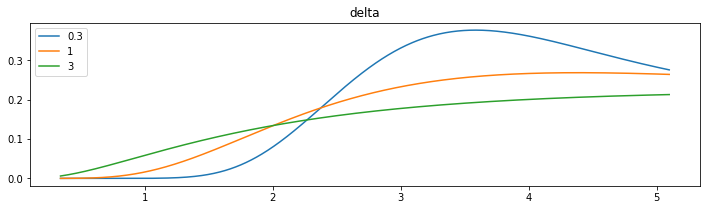

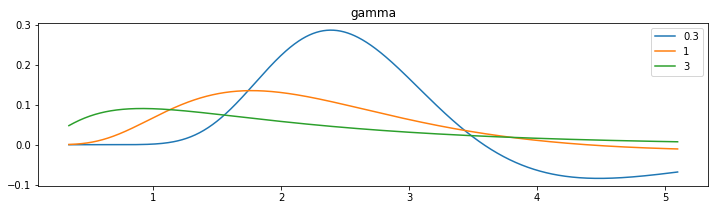

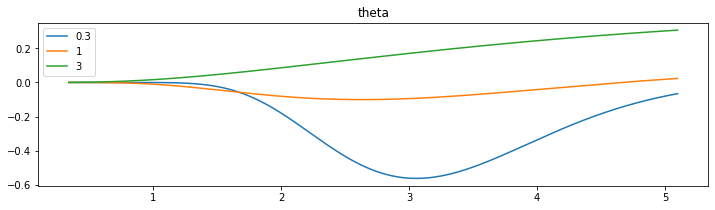

In [173]:
#计算欧式期权和美式期权的greeks，并采用delta hedging
pd.set_option('display.max_columns',None)
print("European Greeks")
cal_greeks(data,X,r,sigma,delta,alpha,"e")

### 3.2 BS模型定价美式期权

American Greeks
total profit -0.030954680709684643
                S  V   delta   gamma   theta  net_inv  gain_on_shares  \
trade_date                                                              
2020-09-01  3.404  0  0.0301  0.0205 -0.0124      NaN          0.0000   
2020-09-02  3.395  0  0.0274  0.0191 -0.0111  10.2605         -0.0246   
2020-09-03  3.387  0  0.0249  0.0174 -0.0101   9.2953         -0.0199   
2020-09-04  3.356  0  0.0152  0.0107 -0.0061   8.4368         -0.0472   
2020-09-07  3.301  0  0.0000  0.0000  0.0000   5.1108         -0.0000   
2020-09-08  3.336  0  0.0090  0.0062 -0.0036   0.0000          0.0315   
2020-09-09  3.285  0  0.0000  0.0000  0.0000   2.9984         -0.0000   
2020-09-10  3.296  0  0.0000  0.0000  0.0000   0.0000          0.0000   
2020-09-11  3.313  0  0.0016  0.0011 -0.0007   0.0000          0.0028   
2020-09-14  3.341  0  0.0106  0.0073 -0.0042   0.5421          0.0296   

            gain_on_written_option  interest  overnight_profit  
trade_d

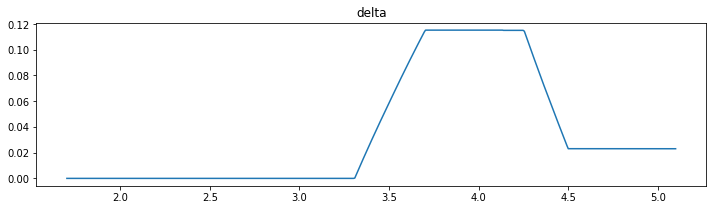

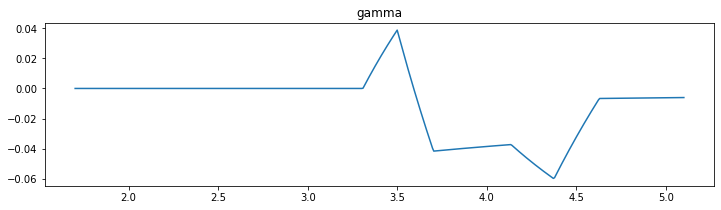

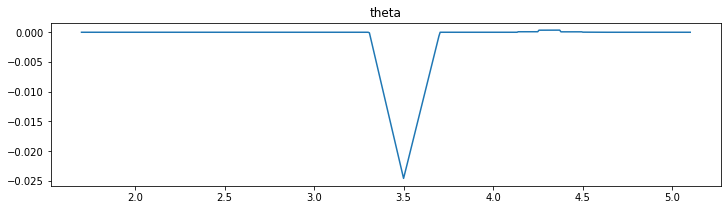

In [174]:
print("American Greeks")
cal_greeks(data,X,r,sigma,delta,alpha,"a")


### 3.3 隐含波动率

In [ ]:
#采用二分法求隐含波动率
n = 100
X = 3.2
S0 = 3.543
Callprice_market = 0.352639
T = 1/12
h = T/n

delta = 0.05/3.5
delta = 0
alpha = 0.2
r = 0.029905

sigma_i = implied_volatility(n, r, delta, X, S0, h, alpha, Callprice_market)

### 附表

In [175]:
df


,Strike Price,n,T,alpha,European Option Price,American Option Price
0,3.0,10,0.019178,0.1,0.340400,0.281674
1,3.0,10,0.082192,0.1,0.340400,0.243196
2,3.0,10,1.000000,0.1,0.340400,0.253241
3,3.0,10,0.019178,0.5,0.410222,0.410222
4,3.0,10,0.082192,0.5,0.469359,0.469359
5,3.0,10,1.000000,0.5,0.957884,0.880881
6,3.0,10,0.019178,1.0,0.410222,0.410222
7,3.0,10,0.082192,1.0,0.469359,0.469359
8,3.0,10,1.000000,1.0,0.986392,0.986392
9,3.0,100,0.019178,0.1,0.340456,0.283574
